```
Copyright (c) Gradient Institute. All rights reserved.
Licensed under the Apache 2.0 License.
```


This notebook demonstrates the effect of feature dimensionality on linear models.

Hahn, P.R., Carvalho, C.M., Puelz, D., He, J., 2018. Regularization and Confounding in Linear Regression for Treatment Effect Estimation. Bayesian Anal. 13. https://doi.org/10.1214/16-BA1044


In [61]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error

from twostageridge import TwoStageRidge, make_combined_stage_scorer

# Generate the data

In [62]:
np.random.seed(42)

projected_dims = np.linspace(10, 300, 5).round().astype(int)
N = 500
rbf_gamma = 1.


# Latent confounders - X
D = 5
mu_x = np.zeros(D)
A = np.random.randn(D, D)
cov_x = A @ A.T / D


# Treatment - Z
sig_eps = 0.6


# Target - Y
alpha = 0.3
sig_nu = 0.6


# Generation function
def generate_data(proj_D):
    
    gamma = np.random.randn(proj_D)
    beta = np.random.randn(proj_D)
    
    # Generate the latent covariates, and then a smooth non-linear function of these
    Xo = np.random.multivariate_normal(mean=mu_x, cov=cov_x, size=N)
    X = RBFSampler(n_components=proj_D, gamma=rbf_gamma).fit_transform(Xo)
    
    # Generate data according to the causal relationships X->Z, X->Y, Z->Y
    Z = X @ gamma + sig_eps * np.random.randn(N)
    Y = alpha * Z + X @ beta + sig_nu * np.random.randn(N)

    W = np.hstack((Z[:, np.newaxis], X))
    
    return W, Y

# Generate bias comparison results

In [63]:
ts = GridSearchCV(
    TwoStageRidge(treatment_index=0),
    param_grid={"regulariser1": [0.01, 0.1, 1, 10], "regulariser2": [0.01, 0.1, 1, 10]},
    cv=5
)

S = 40
models = {
    "ols": LinearRegression(),
    "lasso": LassoCV(n_alphas=20, max_iter=20000),
    "ridge": RidgeCV([0.01, 0.1, 1, 10]),
    "ts": ts
}

n_D = len(projected_dims)
results_dict = {"dimensionality": projected_dims}
results_dict.update({k + "_err": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_err_std": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_bias": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_bias_std": np.zeros(n_D) for k in models.keys()})
results = pd.DataFrame(results_dict).set_index("dimensionality")

In [64]:
for proj_D in projected_dims:
    
    err = {k: np.zeros(S) for k in models.keys()}
    bias = {k: np.zeros(S) for k in models.keys()}
    
    # Sample random datasets
    for s in range(S):

        # Generate the data and split into train and test
        W, Y = generate_data(proj_D)
        W_train, W_test, Y_train, Y_test = train_test_split(W, Y, train_size=0.9)
        
        for name, model in models.items():

            # Fit the model and get the ATE (alpha)
            model.fit(W_train, Y_train)
            alpha_hat = model.best_estimator_.alpha_ if name == "ts" else model.coef_[0]
            bias[name][s] = (alpha - alpha_hat)**2

            # Score on held-out data
            err[name][s] = mean_squared_error(Y_test, model.predict(W_test))

        print('.', end='')
        
    for name in models.keys():
        results.loc[proj_D, name + "_err"] = err[name].mean()
        results.loc[proj_D, name + "_err_std"] = err[name].std()
        results.loc[proj_D, name + "_bias"] = bias[name].mean()
        results.loc[proj_D, name + "_bias_std"] = bias[name].std()
        
    print()
    
results

........................................
........................................
........................................
........................................
........................................


,ols_err,lasso_err,ridge_err,ts_err,ols_err_std,lasso_err_std,ridge_err_std,ts_err_std,ols_bias,lasso_bias,ridge_bias,ts_bias,ols_bias_std,lasso_bias_std,ridge_bias_std,ts_bias_std
dimensionality,,,,,,,,,,,,,,,,
10,0.375233,0.375354,0.375236,0.375520,0.082873,0.081678,0.082792,0.082787,0.002535,0.002315,0.002476,0.002496,0.002416,0.002426,0.002471,0.002382
82,0.441518,0.427834,0.429696,0.429832,0.100783,0.094993,0.090450,0.089399,0.002214,0.001907,0.001991,0.002492,0.002979,0.002544,0.002817,0.004733
155,0.629234,0.516446,0.529879,0.529161,0.159698,0.117171,0.114457,0.116419,0.004209,0.003066,0.003140,0.004113,0.006045,0.003457,0.004100,0.005406
228,1.133726,0.536872,0.539345,0.533423,0.424751,0.105023,0.097618,0.095760,0.004499,0.002445,0.002677,0.004441,0.007804,0.002783,0.003567,0.006171
300,5.166036,0.573578,0.567192,0.563718,4.096745,0.115496,0.097906,0.096307,0.009317,0.003991,0.003701,0.005123,0.010461,0.004157,0.003734,0.005466


# Plot

Text(0.5, 0, 'feature dimensionality')

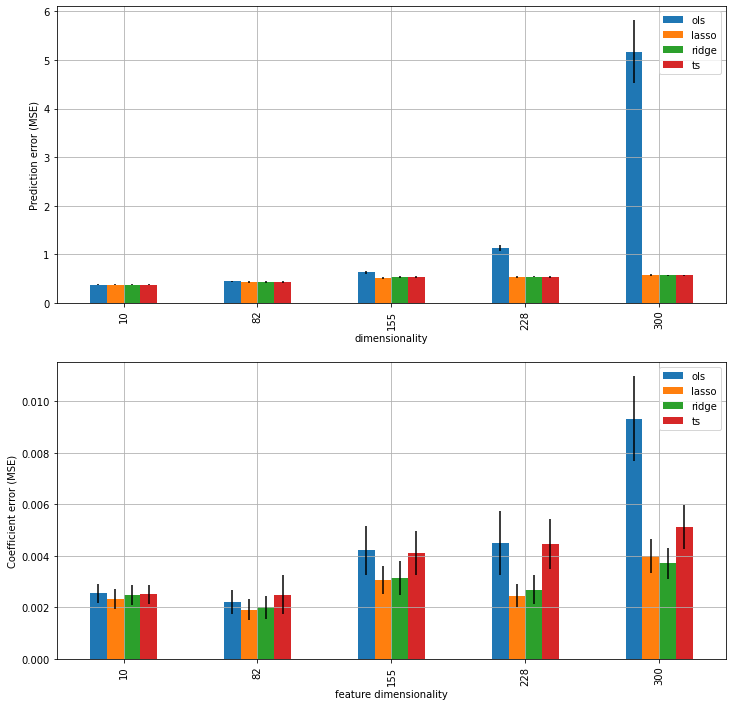

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

#for name in models.keys():
#    ax1.errorbar(
#        results.index,
#        results[name + "_err"],
#        yerr=results[name + "_err_std"] / np.sqrt(S),
#        label=name
#    )
    
pred_errors = [name + "_err" for name in models.keys()]
model_errstd = results[[name + "_err_std" for name in models.keys()]] / np.sqrt(S)
model_errstd.columns = pred_errors
results[pred_errors].plot(kind='bar', yerr=model_errstd, ax=ax1)
    
ax1.set_ylabel("Prediction error (MSE)")
ax1.grid()
ax1.legend(models.keys())

model_biases = [name + "_bias" for name in models.keys()]
model_bstds = results[[name + "_bias_std" for name in models.keys()]] / np.sqrt(S)
model_bstds.columns = model_biases
results[model_biases].plot(kind='bar', yerr=model_bstds, ax=ax2)
    
ax2.set_ylabel("Coefficient error (MSE)")
ax2.grid()
ax2.legend(models.keys())
ax2.set_xlabel("feature dimensionality")